## AERO3000 Space Systems Design

Faculty of Science and Engineering &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp; Space Science and Technology Centre &nbsp;&nbsp;|&nbsp;&nbsp; CRICOS Provider Code 00301J

# Mission Name Power Budget
Modelling the electrical generation, storage and consumption of our space system.

### Orbit
Note this code is only valid for circular orbits.

In [ ]:
#load libraries for JupyterLite
#only required one time ever for JupyterLab running locally or on a hosted JupyterHub instance
%pip install ipywidgets==8.1.1 plotly==5.21.0

In [2]:
from astropy.time import Time #import astropy so we can use the astropy.Time class to set our epoch times
from astropy import units as u #import the astropy units package so we can use real world units conveniently
import numpy as np #import our maths library numpy under the alias np
import plotly.graph_objects as go #import our plotting library under the alias go
from scipy.spatial.transform import Rotation as R #import SciPy rotation library under the alias R for Euler angle rotations

class Earth:
    """Earth class with useful atributes, used as poliastro is not available in JupyterLite"""
    name = "Earth"
    #radius, source: Archinal, B.A. et al. "Report of the IAU working group on cartographic coordinates and rotational elements: 2015"
    #Celestial Mechanics and Dynamical Astronomy 109(2011): 101-135. DOI: https://doi.org/10.1007/s10569-010-9320-4
    R =  6371.0084*u.km
    
    #gravitational parameter GM, source: Luzum, Brian et al. "The IAU 2009 System of Astronomical Constants: The Report of the IAU Working Group on Numerical Standards for Fundamental Astronomy."
    #Celestial Mechanics and Dynamical Astronomy 110.4 (2011): 293–304. DOI: https://doi.org/10.1007/s10569-011-9352-4
    k = 3.986004418e14*u.m**3/u.s**2
    
    #CSS colour name for plotting
    color = "lightskyblue"
    
    #atmosphere properties for plotting
    has_atmosphere = True
    #atmosphere "height" and CSS colour for visualisation
    atmosphere_height = 100*u.km
    atmosphere_color = "lightblue"
    atmosphere_opacity = 0.2

class Moon:
    """Moon class with useful atributes, used as poliastro is not available in JupyterLite"""
    name = "The Moon (Luna)"
    #radius, source: Archinal, B.A. et al. "Report of the IAU working group on cartographic coordinates and rotational elements: 2015"
    #Celestial Mechanics and Dynamical Astronomy 109(2011): 101-135. DOI: https://doi.org/10.1007/s10569-010-9320-4
    R = 1737.1*u.km #mean radius
    
    #gravitational parameter GM
    #source: Lemoine, Frank G. et al. "High-Degree Gravity Models from GRAIL Primary Mission Data."
    #Journal of Geophysical Research: Planets 118.8 (2013): 1676–1698. DOI: https://doi.org/10.1002/jgre.20118
    k = 4.90279981e12*u.m**3/u.s**2
    
    #CSS colour name for plotting
    color = "lightgrey"
    
    #atmosphere properties for plotting
    has_atmosphere = False

In [3]:
def sphere3d(x_0, y_0, z_0, r, res):
    """Sphere surface creation function for use with Plotly go.Surface"""
    phi, theta = np.mgrid[0:np.pi:res*1j, 0:2*np.pi:res*1j] # create a meshgrid with 100 values for phi and 100 values for theta
    xs = x_0+r*np.sin(theta)*np.cos(phi)
    ys = y_0+r*np.sin(theta)*np.sin(phi)
    zs = z_0+r*np.cos(theta)
    
    return xs, ys, zs

def ellipse3d(sma, ecc, inc, raan, argp, res):
    """Ellipse line creation function for use with Plotly go.Scatter3d"""
    theta = np.linspace(0, 2*np.pi, res)
    
    #create ellipse points on a 2d plane
    ellipse_xs = sma*np.cos(theta)-sma*ecc
    ellipse_ys = sma*np.sqrt(1-ecc**2)*np.sin(theta)
    ellipse_zs = 0*theta
    
    #prepare datapoints for rotation matrix multiplication
    #source: https://community.plotly.com/t/controlling-animation-speed-using-graph-objects-in-python/41038/21
    m = ellipse_xs.shape
    xyz = np.vstack((ellipse_xs.flatten(),ellipse_ys.flatten(),ellipse_zs.flatten()))
    
    r = R.from_euler("zxz", [argp, inc, raan]).as_matrix() #create rotation matrix for raan, inc and argp rotations
    
    xyz_rotated = r @ xyz #apply rotation via matrix multiplication
    xs, ys, zs = xyz_rotated[0].reshape(m), xyz_rotated[1].reshape(m), xyz_rotated[2].reshape(m)
    
    return xs, ys, zs

def spacecraftCone(sma, ecc, inc, raan, argp, nu, sc_cone_scale):
    """Function to generate spacecraft position and direction coordinates for use with Plotly go.Cone"""
    step = 0.01 #step in nu for numerical differentiation
    nu0_nu1 = np.asarray([nu, nu+step, nu+2*step]) #calculate nu0 and nu1
    E = np.arctan(np.tan(nu0_nu1/2)/np.sqrt((1+ecc)/(1-ecc)))*2 #calculate eccentric anomaly for true anomaly nu0 and nu1
    
    #calculate spacecraft position on a 2d plane
    ellipse_xs = sma*np.cos(E)-sma*ecc
    ellipse_ys = sma*np.sqrt(1-ecc**2)*np.sin(E)
    ellipse_zs = 0*E
    
    #prepare datapoints for rotation matrix multiplication
    #source: https://community.plotly.com/t/controlling-animation-speed-using-graph-objects-in-python/41038/21
    m = ellipse_xs.shape
    ellipse_xyzs = np.vstack((ellipse_xs, ellipse_ys, ellipse_zs))
    
    r = R.from_euler("zxz", [argp, inc, raan]).as_matrix() #create rotation matrix for raan, inc and argp rotations
    
    xyzs = r @ ellipse_xyzs #apply rotation via matrix multiplication

    xs, ys, zs = xyzs[0].reshape(m), xyzs[1].reshape(m), xyzs[2].reshape(m)
    
    #calculate directions
    uvws = np.diff(xyzs)

    #scale first direction
    scaled_uvws_0 = sc_cone_scale*uvws.transpose()[0]/np.linalg.norm(uvws.transpose()[0])

    # print("Cone :", [xs[0]], [ys[0]], [zs[0]], [scaled_uvws_0[0]], [scaled_uvws_0[1]], [scaled_uvws_0[2]])
    return [xs[0]], [ys[0]], [zs[0]], [scaled_uvws_0[0]], [scaled_uvws_0[1]], [scaled_uvws_0[2]]

In [4]:
class Orbit: #class to create & represent our orbit, to make easy to read attributes like orbit.a & orbit.ecc
    """Orbit class created for orbits in Space Systems Design"""
    def __init__(self, name, body, sma, ecc, inc, raan, argp, nu, epoch):
        self.name = name
        self.body = body #Primary body (that the spacecraft is orbiting)
        self.sma = sma
        self.ecc = ecc*u.dimensionless_unscaled
        self.inc = inc
        self.raan = raan 
        self.argp = argp
        self.nu = nu
        self.epoch = epoch

    def  __str__(self):
        return "Orbit:\n  Name: {}\n  Body: {}\n  Semi-major Axis: a = {:.0f}\n  Eccentricity: e = {:.3f}\n  Inclination: i = {:.1f}\n  Right Ascension of the Ascending Node: Ω = {:.1f}\n  Argument of Perigee: ω = {:.1f}\n  True Anomaly: ν = {:.1f}\n  Orbit Epoch: {} UTC".format(self.name, self.body.name, self.sma.to(u.km), self.ecc.to(u.dimensionless_unscaled), self.inc.to(u.deg), self.raan.to(u.deg), self.argp.to(u.deg), self.nu.to(u.deg), Time(self.epoch, format="iso", scale="utc"))

o = Orbit(name = "Mission Orbit",
          body = Earth,
          sma = Earth.R+570*u.km,
          ecc = 0*u.dimensionless_unscaled,
          inc = (97*u.deg).to(u.rad),
          raan = (-22.5*u.deg).to(u.rad),
          argp = (0*u.deg).to(u.rad),
          nu = (0*u.deg).to(u.rad),
          epoch = Time("2026-03-23 09:00:00.000", format="iso", scale="utc"))

# o = Orbit(name = "Mission Orbit",
#           body = Moon,
#           sma = 20000*u.km,
#           ecc = 0.7*u.dimensionless_unscaled,
#           inc = (90*u.deg).to(u.rad),
#           raan = (0*u.deg).to(u.rad),
#           argp = (90*u.deg).to(u.rad),
#           nu = (0*u.deg).to(u.rad),
#           epoch = Time("2026-03-23 09:00:00.000", format="iso", scale="utc"))

print(o)

Orbit:
  Name: Mission Orbit
  Body: Earth
  Semi-major Axis: a = 6941 km
  Eccentricity: e = 0.000
  Inclination: i = 97.0 deg
  Right Ascension of the Ascending Node: Ω = -22.5 deg
  Argument of Perigee: ω = 0.0 deg
  True Anomaly: ν = 0.0 deg
  Orbit Epoch: 2026-03-23 09:00:00.000 UTC


## Calculate Your Power Generation Availability Over Time
This code assumes you are generating at the beginning of the modelled time period.

Update this code to model the power generation for your mission.

### Calculate Your Eclipse Periods

In [13]:
day_number = o.epoch.datetime.timetuple().tm_yday #calculate the day number of the year using datetime
d0 = 79 #assuming day 0 is 21 march as on page 120 of Fortescue et al. (2011)
print("Days since 1 January: {} days".format(day_number)) #print days

#calculate L_sun from day number and d0
L_sun = ((day_number-d0)/365*360*u.deg).to(u.rad)
print("L_sun: {:.2f}".format(L_sun))

epsilon = 23.45*u.deg #obliquity of the ecliptic from page 119 of Fortescue et al. (2011)

#calculate the sun vector from L_sun and epsilon, from equation 5.7 in Fortescue et al. (2011)
r_sun = np.array([np.cos(L_sun),
                  np.sin(L_sun)*np.cos(epsilon),
                  np.sin(L_sun)*np.sin(epsilon)])

print("Sun unit vector: {}".format(r_sun))

beta = np.arcsin(Earth.R/o.sma)
print("beta = {:.3f}".format(beta))

anti_r_sun = -r_sun
print("anti-Sun unit vector: {}\n".format(anti_r_sun))

#Create two empty lists so we can use the append method to build them 
theta_list = []
in_eclipse_list = []

for i in np.arange(0, 360, 1): #loop over one orbit, true anomaly from 0 to 360 with a step of one degree
    theta = (i*u.deg).to(u.rad)
    #equation 5.8 in Fortescue et al. (2011)
    r_spacecraft = np.array([np.cos(o.raan)*np.cos(theta+o.argp)-np.sin(o.raan)*np.cos(o.inc)*np.sin(theta+o.argp),
                             np.sin(o.raan)*np.cos(theta+o.argp)+np.cos(o.raan)*np.cos(o.inc)*np.sin(theta+o.argp),
                             np.sin(o.inc)*np.sin(theta+o.argp)])
    
#     print("Spacecraft unit vector = {}".format(r_spacecraft))

    #relational expression to see when spacecraft is in eclipse
    #look up NumPy vector operations
    in_eclipse = np.arccos(np.dot(anti_r_sun, r_spacecraft))*u.rad<=beta
    
    #append to lists
    theta_list.append(theta.to(u.deg).value)
    in_eclipse_list.append(in_eclipse)
    
theta_array = np.asarray(theta_list)*u.deg
in_eclipse_array = np.asarray(in_eclipse_list)

in_sunlight_array = np.invert(in_eclipse_array) #calculate when in sunlight from the inverse of when in eclipse

#calculate the orbital period from the semi-major axis and gravitational parameter for Earth
#using equation 4.12 from Fortescue et al. (2011) which is derived from Kepler's third law
#and remembering to convert to minutes in case the calculation ends up in another unit
tau = 2*np.pi*np.sqrt(o.sma**3/Earth.k).to(u.min)

#print results
print("Orbital Period: {:.1f}".format(tau))

#calculate the mean motion n (see equation 4.17 and refer to the table of 4.1)
n = 2*np.pi*u.rad/tau
print("Mean Motion n: {:.2e}\n".format(n.to(u.rad/u.s)))

#create t array from the theta array using the mean motion
t = (theta_array/n).to(u.min) #create a time array from 0 to (nearly) tau using the mean motion n

sunlight_fraction = np.mean(in_sunlight_array)
print("Spacecraft in sunlight {:.2%} of the time".format(sunlight_fraction))

# print(theta_array)
# print(t)
# print(in_eclipse_array)

Days since 1 January: 82 days
L_sun: 0.05 rad
Sun unit vector: [0.99866682 0.04735628 0.02054198]
beta = 1.163 rad
anti-Sun unit vector: [-0.99866682 -0.04735628 -0.02054198]

Orbital Period: 95.9 min
Mean Motion n: 1.09e-03 rad / s

Spacecraft in sunlight 64.72% of the time


### Plot Your Orbit

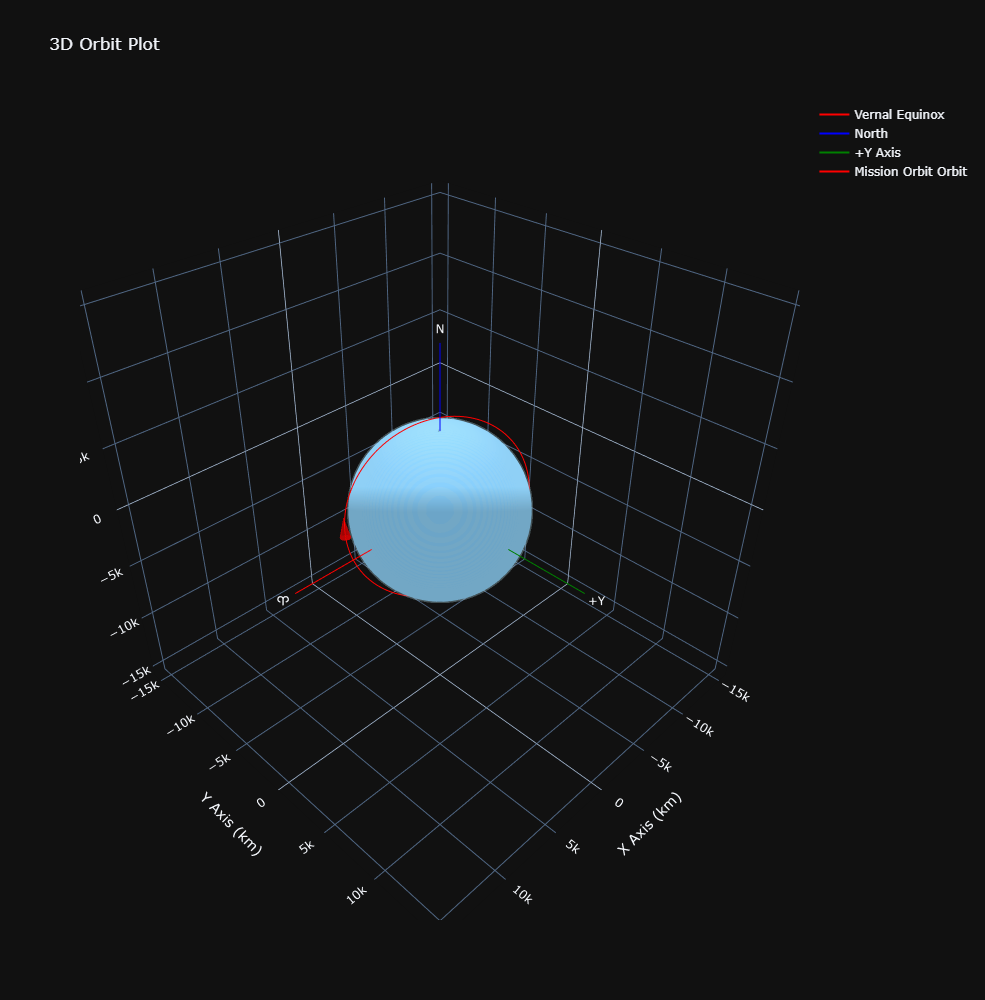

In [14]:
# body to that the orbits will be plotted around
body = o.body

#resolution of orbit and body in plots
orbit_res = 200 #number of points used to plot ellipse
body_res = 70 #numbe or points to use in meshgrid creation

#size of 3d viewbox
box_scale = 5 #viewbox cube sidelength in body radii

#height of 3d plot figure
figure_height = 1000

#scaling factor for the size of the cone representing spacecraft position and direction, relative to the radius of the body
sc_cone_scale = body.R.to(u.km).value/2

#create a scatter plot from the x and y arrays
fig = go.FigureWidget()

fig.layout.template = "plotly_dark" #change plotly theme to dark mode

#update figure layout as needed
fig.update_layout(
    title_text="3D Orbit Plot", #set figure title
    #set height & activate width autosize
    height=figure_height,
    autosize=True,
    showlegend=True,
    scene=dict(
        #specify the aspect ratio as 1:1:1 to avoid squished objects after we set set the bounds
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1),
        #set the view box size
        xaxis=dict(nticks=8, range=[-box_scale/2*body.R.to(u.km).value,box_scale/2*body.R.to(u.km).value],),
        yaxis=dict(nticks=8, range=[-box_scale/2*body.R.to(u.km).value,box_scale/2*body.R.to(u.km).value],),
        zaxis=dict(nticks=8, range=[-box_scale/2*body.R.to(u.km).value,box_scale/2*body.R.to(u.km).value],),
        #set axes titles
        xaxis_title="X Axis (km)",
        yaxis_title="Y Axis (km)",
        zaxis_title="Z Axis (km)"),
    #define the view angle
    # scene_camera_eye=dict(x=0.5*np.pi, y=0.5*np.pi, z=0.5*np.pi)
    )

#add the body to the graph
body_xs, body_ys, body_zs = sphere3d(0, 0, 0, body.R.to(u.km).value, body_res) #create the body sphere surface
fig.add_trace(go.Surface(x=body_xs, y=body_ys, z=body_zs, name=body.name, colorscale=[[0,body.color], [1, body.color]], showscale=False)) #add the body to the graph

if(body.has_atmosphere):
    #add the atmosphere to the graph
    atmosphere_xs, atmosphere_ys, atmosphere_zs = sphere3d(0, 0, 0, body.R.to(u.km).value+body.atmosphere_height.to(u.km).value, body_res) #create the body sphere surface
    fig.add_trace(go.Surface(x=atmosphere_xs, y=atmosphere_ys, z=atmosphere_zs, name=body.name+"Atmosphere", colorscale=[[0,body.atmosphere_color], [1, body.atmosphere_color]], opacity=body.atmosphere_opacity, showscale=False)) #add the body to the graph

#add the Vernal Equinox reference to the plot
fig.add_trace(go.Scatter3d(x=[0, 2*body.R.to(u.km).value], y=[0,0], z=[0,0], mode="lines", marker_color="red", name="Vernal Equinox")) #add line to graph
fig.add_trace(go.Scatter3d(x=[2.15*body.R.to(u.km).value], y=[0,0], z=[0,0], mode="text", text="♈︎", textposition="middle center", showlegend=False)) #add text to graph
#add the North reference to the plot
fig.add_trace(go.Scatter3d(x=[0,0], y=[0,0], z=[0, 2*body.R.to(u.km).value], mode="lines", marker_color="blue", name="North")) #add line to graph
fig.add_trace(go.Scatter3d(x=[0,0], y=[0,0], z=[2.15*body.R.to(u.km).value], mode="text", text="N", textposition="middle center", showlegend=False)) #add text to graph
#add the +Y reference to the plot
fig.add_trace(go.Scatter3d(x=[0,0], y=[0, 2*body.R.to(u.km).value], z=[0,0], mode="lines", marker_color="green", name="+Y Axis")) #add line to graph
fig.add_trace(go.Scatter3d(x=[0,0], y=[2.15*body.R.to(u.km).value], z=[0,0], mode="text", text="+Y", textposition="middle center", showlegend=False)) #add text to graph

#add the orbit ellipse to the graph
orbit_xs, orbit_ys, orbit_zs = ellipse3d(o.sma.to(u.km).value, o.ecc.to(u.dimensionless_unscaled).value, o.inc.to(u.rad).value, o.raan.to(u.rad).value, o.argp.to(u.rad).value, orbit_res) #create orbit ellipse
fig.add_trace(go.Scatter3d(x=orbit_xs, y=orbit_ys, z = orbit_zs, mode="lines", marker_color="red", name=o.name+" Orbit")) #add ellipse to graph

#add a cone for the spacecraft
sc_xs, sc_ys, sc_zs, sc_us, sc_vs, sc_ws = spacecraftCone(o.sma.to(u.km).value, o.ecc.to(u.dimensionless_unscaled).value, o.inc.to(u.rad).value, o.raan.to(u.rad).value, o.argp.to(u.rad).value, o.nu.to(u.rad).value, sc_cone_scale)
fig.add_trace(go.Cone(x=sc_xs, y=sc_ys, z=sc_zs, u=sc_us, v=sc_vs, w=sc_ws, name=o.name+" Spacecraft", colorscale=[[0,"red"], [1, "red"]], opacity=0.5, showscale=False))

fig #display the figure

### Plot Illumination Status Over Time for One Orbit

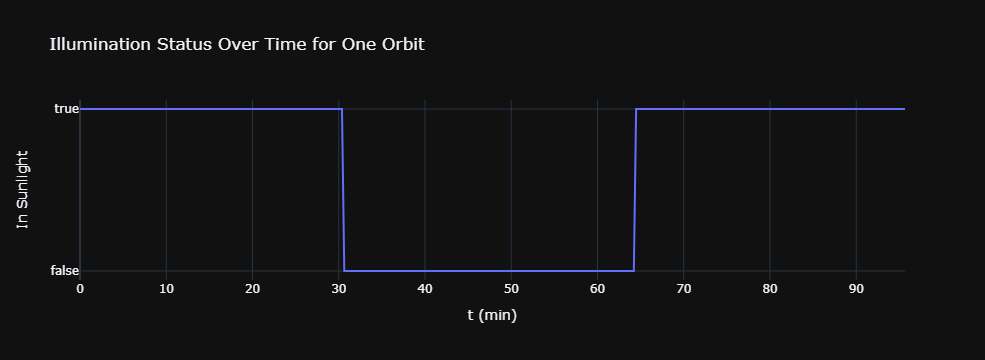

In [7]:
fig = go.Figure(data=go.Scatter(x=t, y=in_sunlight_array)) #create a scatter plot from the in_eclipse_theta_array and in_eclipse_array
fig.layout.template = "plotly_dark" #activate the dark theme, comment out for light theme if you want

fig.update_yaxes(autorange="reversed") #flip y axis, comment out to unflip if required

fig.update_layout(title="Illumination Status Over Time for One Orbit", #add figure title and axis titles
                  xaxis_title="t ({})".format(t.unit),
                  yaxis_title="In Sunlight",
                  )

fig #display figure

## Power Consumption
### Enter Power Draws for Different Operational Modes

In [8]:
p_idle = 11*u.W #idle
p_imaging = 14*u.W #imaging payload in use
p_processing = 21.5*u.W #payload processor in use
p_comms_contact = 28*u.W #concurrent uplink and downlink
p_repointing = 13*u.W #high usage of ADCS to repoint spacecraft
p_orbital_maintenance_burn = 15*u.W #small electric propulsion system in use for orbital maintenance
p_orbit_raising_burn = 8*u.W #small electric propulsion system in use for orbit raising

### Enter the Timing of the Different Modes

In [9]:
power_consumption = np.ones(t.shape)*u.W #array of p_data_processing, same shape as t
imaging_start = 5*u.min
imaging_duration = 10*u.min
processing_start = 20*u.min
processing_duration = 20*u.min
repointing_duration = 1*u.min
comms_contact_start = 45*u.min
comms_contact_duration = 10*u.min
orbital_maintenance_burn_start = tau*0.7
orbital_maintenance_burn_duration = tau*0.25

### Calculate Consumption

In [10]:
for i in range(len(t)):
    time = t[i]
    if ((imaging_start<=time) & (time<imaging_start+imaging_duration)): #imaging
        power_consumption[i] = p_imaging
    elif ((processing_start<=time) & (time<processing_start+processing_duration)): #processing
        power_consumption[i] = p_processing
    elif ((comms_contact_start-repointing_duration<=time) & (time<comms_contact_start)): #repointing before comms contact
        power_consumption[i] = p_repointing
    elif ((comms_contact_start<=time) & (time<comms_contact_start+comms_contact_duration)): #comms contact
        power_consumption[i] = p_comms_contact
    elif ((comms_contact_start+comms_contact_duration<=time) & (time<comms_contact_start+comms_contact_duration+repointing_duration)): #repointing after comms contact
        power_consumption[i] = p_repointing
    elif ((orbital_maintenance_burn_start-repointing_duration<=time) & (time<orbital_maintenance_burn_start)): #repointing before orbital maintenance burn
        power_consumption[i] = p_repointing
    elif ((orbital_maintenance_burn_start<=time) & (time<orbital_maintenance_burn_start+orbital_maintenance_burn_duration)): #orbital maintenance burn
        power_consumption[i] = p_orbital_maintenance_burn
    elif ((orbital_maintenance_burn_start+orbital_maintenance_burn_duration<=time) & (time<orbital_maintenance_burn_start+orbital_maintenance_burn_duration+repointing_duration)): #repointing after orbital maintenance burn
        power_consumption[i] = p_repointing
    else:
        power_consumption[i] = p_idle

### Plot the Power Consumption Over One Orbit

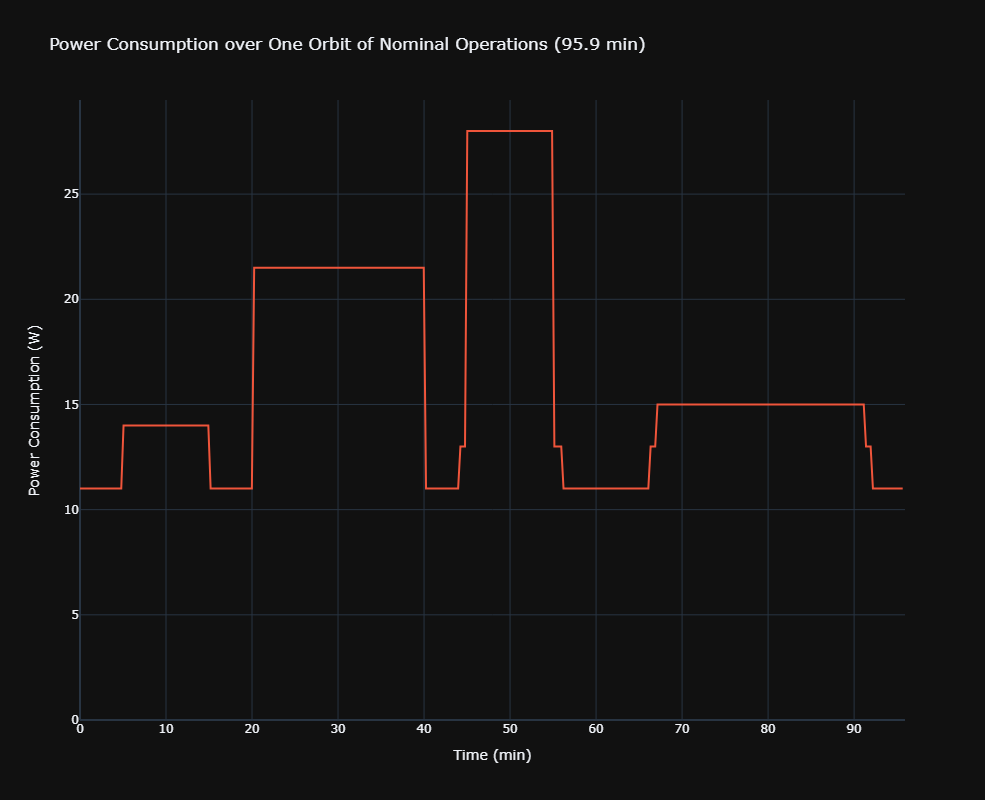

In [11]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=1)
fig.layout.template = 'plotly_dark' #activate the dark theme, comment out for light theme if you want

fig.add_trace(go.Scatter(x=t, y=power_consumption, name="Power Consumption ({})".format(power_consumption.unit), line=dict(color="#EF553B"), showlegend=False), row=1, col=1)

fig.update_yaxes(title_text="Power Consumption ({})".format(power_consumption.unit), rangemode="tozero", row=1, col=1)

fig.update_xaxes(range=[0, (tau).to(u.min).value], row=1, col=1)
fig.update_xaxes(title_text="Time ({})".format(t.unit), range=[0, (tau).to(u.min).value], row=1, col=1)

fig.update_layout(title_text="Power Consumption over One Orbit of Nominal Operations ({:.1f})".format(tau.to(u.min)),
                  height=800)

fig #display figure

## Power Generation
(This is similar to section 10.6.3 in [chapter 10 "Electrical Power Systems" in Fortescue et al. (2011)](https://onlinelibrary-wiley-com.dbgw.lis.curtin.edu.au/doi/pdf/10.1002/9781119971009.ch10) on page 352.)

First: calculate your average power consumption:

In [12]:
p_avg = np.???(power_consumption)
print("Average power consumption: p_avg = {:.1f}".format(p_avg))

SyntaxError: invalid syntax (2932107889.py, line 1)

To do the next step we will need to know the availability of the generation source (in sunlight fraction for solar power):

In [ ]:
frac_gen_available = sunlight_fraction
print("Availabity of generation : frac_gen_available = {:.0%}".format(frac_gen_available))

Then make an initial estimate of the required power generation by dividing by the availability of the generation source.

Keep in mind that this initial guess doesn't take into account different factors degrading the generation output such as temperature or radiation dose effects (damage) over time or inefficiencies in the system.

In [ ]:
p_gen_initial_estimate = ???/???
print("Initial estimate of power generation capacity : p_gen_initial_estimate = {:.0f}".format(p_gen_initial_estimate))

### Cell Selection
Select an [Azure Space](http://www.azurspace.com/index.php/en/) or [Rocket Lab SolAero](https://www.rocketlabusa.com/space-systems/solar/space-solar-cellscics/) **space** solar cell and calculate the **active** cell area required to deliver this power generation capcity.

Assume J_S = 1371 W/m$^2$ and that the panels remain normal to the Sun vector at all times.

Update the comment to include the cell assembly type and the link to the datasheet.

Print the result in centimetres squared.

In [ ]:
# Update Solar radiaiton flux if not around 1 AU from the Sun
J_S = 1371*u.W/u.m**2 #solar radiation flux from Fortescue et al. (2011) page 359
eff_cell = ???/100 #<cell assembly type>, source: <cell assembly datasheet>

initial_estimate_cell_area = p_gen_initial_estimate/J_S/eff_cell
print("Initial estimate cell active area: initial_estimate_cell_area = {:.0f}".format(initial_estimate_cell_area.to(u.cm*u.cm)))

Calculate the number of cell assemblies from the cell area if given in the datasheet. If not provided, you could assume cell area is 30.18 cm$^2$.

In [ ]:
area_per_cell = ???*u.cm**2 #<cell assembly type>

#calculate number of cells, rounding up using the np.ceil() funciton
inital_estimate_n_cells =  np.ceil((initial_estimate_cell_area/area_per_cell).to(u.dimensionless_unscaled))

print("Initial estimate number of cells: inital_estimate_n_cells = {:.0f}".format(inital_estimate_n_cells))

### Calculate Losses

Assume battery charging is 90% efficient.

Assume degradation due to temperature rise is approximately 0.2 % per °C above room temperature (assumption is roughly based on [Rocket Lab SolAero ZTJ datasheet](https://www.rocketlabusa.com/assets/Uploads/RL-SolAero-Data-Sheet-ZTJ.pdf)). If you haven't done a thermal balance yet assume your cells are around 70 °C in an Earth orbit (although you should do a thermal balance calculation ASAP).

Assume a degradation due to radiation based on [Table 6.7 from Brown (2002) p. 339](https://ebookcentral.proquest.com/lib/curtin/reader.action?docID=3111499&ppg=352) and your mission parameters.

In [ ]:
eff_charging = 90/100 #90% efficient solar tracking and cell charging
radiation_degradation_loss = ???/100 #<insert mission information>, based on Brown (2002) p. 339
temperature_loss = ???/100 #assumption rougly based on figure 6.18 on page 337 of Brown (2002)

### Determine Cell Area

Now pick your actual cell area or number of cells which should be informed by your initial estimates. (It should be larger, however.)

If you want, you can just pick you initial estimate for now, and then come back and refine it after the initial run of the model. An iterative approach like this is reasonable.

In [ ]:
n_cells = ???
cell_area = n_cells * area_per_cell

### Calculate the Power Generation Over Time

Fill in the missing power generation capacity expression accounting for the losses below and then run the code.

Note that the expression for efficiencies will be different than the expression for losses.

In [ ]:
# calculate your power generation capacity with losses
p_gen_capacity = (J_S*eff_cell*cell_area*???*???*???).to(u.W)
print("Power generation with losses: p_gen_capacity = {:.1f}".format(p_gen_capacity))

Now calculate your power generation over time array by multiplying the capacity (scalar) times the availability (array).

In [ ]:
power_generation = ???*???

## Power Modelling of Nominal Operations
For now we are going to assume the batteries start empty and you have a very large battery capacity.

You should come back and improve these assumptions as you progress the design of your space system's electrical power system.

Fill in the missing expression to calculate the next energy storage level (it's a numerical integration of power over time) and then run the code below.

Also fill in the missing part of the expression to limit the maximum level of stored energy to the battery pack capacity.

In [ ]:
e0 = 0*u.W*u.h # initial energy storage level
energy_storage_capacity = 1000*u.W*u.h #energy storage limit (battery pack capacity)

energy_stored = np.zeros(t.shape)*u.W*u.h #create array of zeroes the same shape as t

delta_t = t[1]-t[0]

for i in range(len(t)):
    time = t[i]
    if i==0:
        energy_stored[i] = e0
    else:
        next_energy_storage_level = energy_stored[i-1]+???
        if(next_energy_storage_level > ???):
            energy_stored[i] = energy_storage_capacity
        else:
            energy_stored[i] = next_energy_storage_level

from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1)

print("Energy stored after one orbit: {:.2f} WH".format(energy_stored[-1].to(u.W*u.h).value))
print("Minimum storage state: {:.2f} WH".format(energy_stored.min().to(u.W*u.h).value))
print("Maximum storage state: {:.2f} WH".format(energy_stored.max().to(u.W*u.h).value))


fig.layout.template = 'plotly_dark' #activate the dark theme, comment out for light theme if you want

fig.add_trace(go.Scatter(x=t, y=power_generation, name="Power Generation (W)", line=dict(color="#636EFA"), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=t, y=power_consumption, name="Power Consumption (W)", line=dict(color="#EF553B"), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=energy_stored, name="Energy Stored (WH)", line=dict(color="#00CC96"), showlegend=False), row=3, col=1)

fig.update_yaxes(title_text="Power Generation (W)", rangemode="tozero", row=1, col=1)
fig.update_yaxes(title_text="Power Consumption (W)", rangemode="tozero", row=2, col=1)
fig.update_yaxes(title_text="Energy Stored (WH)", rangemode="tozero", row=3, col=1)

fig.update_xaxes(range=[0, (tau).to(u.min).value], row=1, col=1)
fig.update_xaxes(range=[0, (tau).to(u.min).value], row=2, col=1)
fig.update_xaxes(title_text="Time ({})".format(t.unit), range=[0, (tau).to(u.min).value], row=3, col=1)

fig.update_layout(title_text="Power Generation, Power Consumption and Energy Storage Over One Orbit of Nominal Operations ({:.2f})".format(tau.to(u.min)),
                  height=1000,
                  showlegend=True,
                  legend=dict(traceorder="normal"),
                  barmode="stack")

fig #display figure

### Go Back and Select a Realistic Battery Pack Capacity and Initial Charge Level
Also check that you don't run out of power at any point. You may wish to move loads around (in time) if you have high power consumption when generation is not available.

Remember, you never what your space system to run out of power.

### Depth of Discharge
From the green trace above determine the depth of discharge and record it in the text box below as a percentage.

### Chose a Cell Chemistry
Write the chosen chemistry in the text box below.

### Projected Lifetime with Chosen Chemistry and Depth of Discharge
Update code for your chemistry and mission.

In [ ]:
# Number of charge-discharge cycles per orbit
charge_cycles_per_orbit = 1
#The cell chemsitry cycle life at the chosen depth of discharge
cell_cycle_life_at_dod = 2000
battery_pack_lifetime = (charge_cycles_per_orbit*cell_cycle_life_at_dod*tau).to(u.yr)
print("Battery Pack Lifetime: {:.2}".format(battery_pack_lifetime))

end_of_life_capacity_ratio = 0.6
eol_remaining_capacity = (energy_storage_capacity*end_of_life_capacity_ratio).to(u.W*u.hr)
print("Battery Pack Capacity Remaining at End of Life: {:.0f} WH".format(eol_remaining_capacity.value))

### Add in a Safety Factor and Print your Panel and Battery Pack Capacity

In [ ]:
#add your code here

### Battery Mass
Look up the energy density of your chosen chemistry, and calculate the approximate mass of your battery pack below. Feel free to rely on easily available sources for this, you don't necessarily need to use a high quality source for this step.

If you would like to look at some space battery cells, you can if you wish.

## Extension
Estimate the mass of your solar arrays. Account for the cells, the structure, and any interface layers or wiring if required.

Update your system's mass budget.

# References

[Brown, Charles D. 2002. *Elements of Spacecraft Design*. Reston, Virginia, USA: American Institute of Aeronautics and Astronautics.](https://ebookcentral.proquest.com/lib/curtin/detail.action?pq-origsite=primo&docID=3111499)

[Fortescue, Peter, Graham Swinerd, and John Stark, eds. 2011. *Spacecraft Systems Engineering*. Chichester, UK: John Wiley & Sons.](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781119971009)